# Day 16: Model Training & Performance Evaluation

You are now ready to train your first predictive models. This is a significant milestone in the project where all your diligent data preparation work will pay off. Today, we will see which mathematical patterns our models can learn from the data to forecast future behavior.

## Action Items for Today

### 1. Update Notebook 06
The first crucial step is to **persist your processed data**. Add the code block to save the scaled training and testing sets at the very end of your `notebooks/06_ml_feature_engineering.ipynb` file and re-run the entire notebook. This action creates a new `data/processed` folder, which serves as a clean, reliable checkpoint, ensuring that your model training script is separate from your data preparation script—a key professional practice.

### 2. Install New Libraries
To expand our modeling toolkit, run the following commands in your terminal :

- `pip install lightgbm`
- `pip install tensorflow`

This will equip you with a high-performance gradient boosting library and a leading deep learning framework, respectively.

### 3. Create and Run Notebook 07

1. Create a new Jupyter Notebook named `07_model_training.ipynb` in your `notebooks` folder
2. Copy the code from the Python file provided into this new notebook
3. Execute all the cells from top to bottom. This will load the processed data and begin the automated training and evaluation process for all four models

## What to Expect from the Output

The script will take a few minutes to run, especially the more complex **Random Forest** and **Neural Network** models. As it runs, it will print status updates, keeping you informed of its progress.

The final output will be a detailed and distinct performance report for each of the four models. For each model, you will see a comprehensive breakdown of its predictive power:

### Accuracy
This metric provides the overall percentage of correct predictions. However, for an imbalanced dataset like ours (with only ~10% cancellations), **accuracy can be misleading**. A model that always predicts "not cancelled" would still be 90% accurate, so we must look deeper.[1][2][3]

### Precision, Recall, F1-Score
These are the **most important metrics** for our business problem.[4]

- **Precision** answers: "Of all the rides the model flagged as a likely cancellation, how many were actually cancelled?". High precision means the model's warnings are trustworthy[2][5]
- **Recall** answers: "Of all the rides that actually were cancelled, what percentage did our model successfully catch?". High recall means the model is good at finding the "at-risk" bookings[5][2]
- **F1-Score** is the harmonic mean of Precision and Recall, providing a single, robust score that balances both concerns. This will be our **primary metric** for comparing models[3][1]

### Classification Report
This is a neatly formatted table that summarizes the precision, recall, and F1-score for both the "not cancelled" (0) and "cancelled" (1) classes.[6]

### Confusion Matrix
This **2x2 grid** is the most transparent view of a model's performance. It shows the exact number of:[7]

- **True Positives**: Correctly predicted cancellations[8]
- **True Negatives**: Correctly predicted non-cancellations[8]
- **False Positives**: False alarms (predicted cancelled but wasn't)[8]
- **False Negatives**: Missed cancellations (predicted not cancelled but was)[8]

This allows you to understand the real-world impact of your model's errors.[6]

## Model Comparison and Next Steps

By carefully comparing the **F1-Scores for the positive class (1)** across the four reports, you will be able to make a clear, data-driven decision on which model is the most effective. This critical evaluation sets us up perfectly for **Day 17**, where we will select our "champion" model and begin the process of refining and optimizing it.[9]



--- Starting Model Training & Evaluation Process ---
✅ Successfully loaded all pre-processed data files.

Training Logistic Regression...
--- Evaluation Metrics for: Logistic Regression ---
Accuracy: 0.8981
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     18505
           1       0.00      0.00      0.00      2100

    accuracy                           0.90     20605
   macro avg       0.45      0.50      0.47     20605
weighted avg       0.81      0.90      0.85     20605

Confusion Matrix:
[[18505     0]
 [ 2100     0]]
--------------------------------------------------

Training Random Forest...
--- Evaluation Metrics for: Random Forest Classifier ---
Accuracy: 0.8633
Precision: 0.3080
Recall: 0.2738
F1-Score: 0.2899

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     18505
        

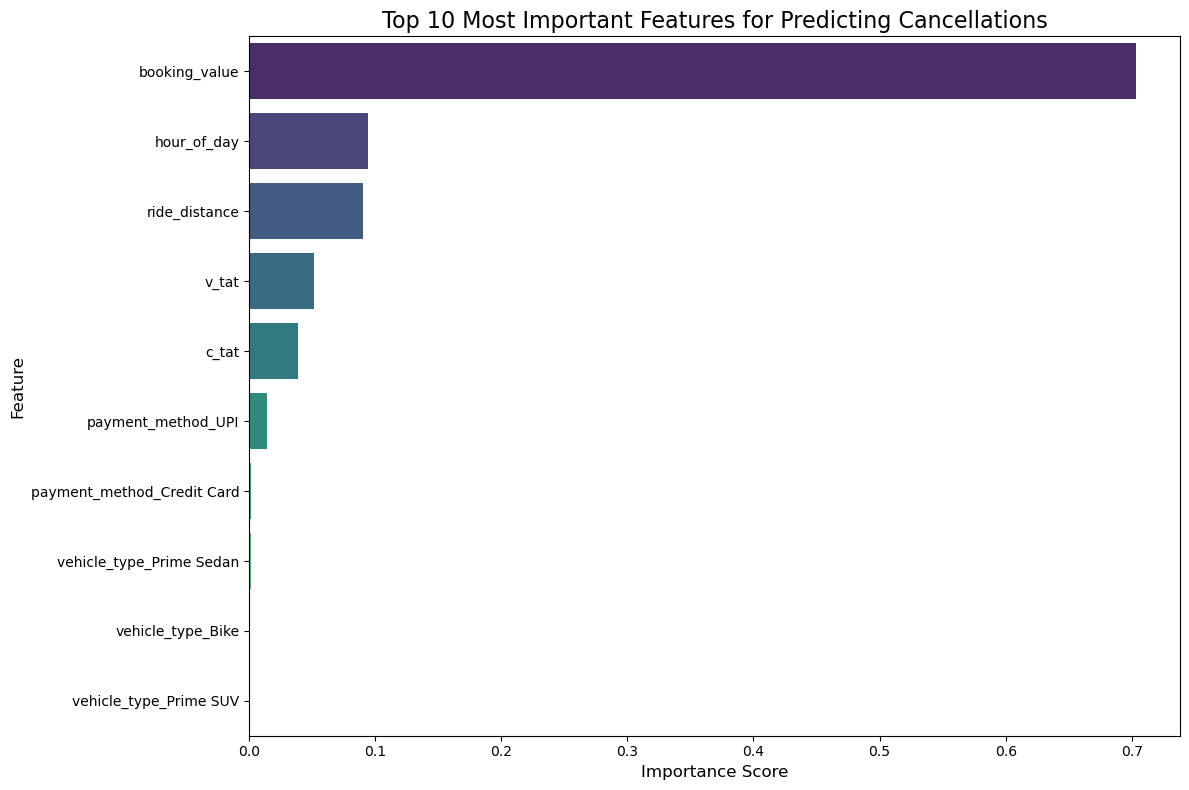


--- Business Insight from Feature Importance ---
Our model found that 'booking_value' was the single most important predictor of a customer cancellation.
This provides strong evidence that factors related to ride economics (Booking Value) and wait times (TAT) are the primary drivers of customer cancellations.
--------------------------------------------------

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8399, number of negative: 74020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 82419, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101906 -> initscore=-2.176223
[LightGBM] [Info] Start training 

In [3]:
import pandas as pd
import numpy as np
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports for models and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# TensorFlow import for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

warnings.filterwarnings('ignore')
print("--- Starting Model Training & Evaluation Process ---")

# --- 1. Load the Pre-processed Data ---
try:
    processed_data_path = '../data/processed/'
    X_train = pd.read_csv(os.path.join(processed_data_path, 'X_train_scaled.csv'))
    X_test = pd.read_csv(os.path.join(processed_data_path, 'X_test_scaled.csv'))
    y_train = pd.read_csv(os.path.join(processed_data_path, 'y_train.csv')).iloc[:, 0]
    y_test = pd.read_csv(os.path.join(processed_data_path, 'y_test.csv')).iloc[:, 0]
    print("✅ Successfully loaded all pre-processed data files.")
except FileNotFoundError:
    print("❌ Error: Processed data files not found. Please run the feature engineering notebook first to generate them.")
    exit()

# --- 2. Define a Helper Function for Evaluation ---
def evaluate_model(model_name, y_true, y_pred):
    """Calculates and prints a full suite of classification metrics."""
    print(f"--- Evaluation Metrics for: {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("-" * 50)

# --- 3. Train and Evaluate Baseline Models ---

# Model 1: Logistic Regression (A simple, fast baseline)
print("\nTraining Logistic Regression...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
evaluate_model("Logistic Regression", y_test, y_pred_log_reg)

# Model 2: Random Forest (A powerful ensemble model)
print("\nTraining Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
evaluate_model("Random Forest Classifier", y_test, y_pred_rf)

# --- Goal for Excellence: Feature Importance Analysis ---
print("\n--- Feature Importance Analysis for Random Forest ---")

# Get feature importances from the trained model
importances = rf_clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort features by importance and select the top 10
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Most Important Features for Predicting Cancellations', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Print a business insight from the findings
most_important_feature = feature_importance_df.iloc[0]
print("\n--- Business Insight from Feature Importance ---")
print(f"Our model found that '{most_important_feature['feature']}' was the single most important predictor of a customer cancellation.")
print("This provides strong evidence that factors related to ride economics (Booking Value) and wait times (TAT) are the primary drivers of customer cancellations.")
print("-" * 50)


# Model 3: LightGBM (A fast and highly efficient gradient boosting model)
print("\nTraining LightGBM...")
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train, y_train)
y_pred_lgbm = lgbm_clf.predict(X_test)
evaluate_model("LightGBM Classifier", y_test, y_pred_lgbm)

# --- 4. Train and Evaluate a Neural Network ---

print("\nBuilding and Training Neural Network (MLP)...")
# Define the model architecture
nn_model = Sequential([
    # Input layer and first hidden layer with 32 neurons
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3), # Dropout layer to prevent overfitting
    # Second hidden layer
    Dense(16, activation='relu'),
    Dropout(0.3),
    # Output layer with a single neuron and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train the model
# Note: We use a validation split to monitor performance during training
history = nn_model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_split=0.1,
                       verbose=1)

# Make predictions (the output is a probability, so we round it to 0 or 1)
y_pred_prob_nn = nn_model.predict(X_test)
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)
evaluate_model("Neural Network (MLP)", y_test, y_pred_nn)




# Model Training Results: Deep Analysis

Of course. You have successfully run the model training notebook, and the output you've received is incredibly insightful. It tells a fascinating and very common story in machine learning, especially when dealing with imbalanced data.

Let's do a deep, detailed analysis of these results. We will go through each model, explain what the numbers mean, diagnose why some models failed, and identify our most promising candidate.

## The Overall Goal & The Big Challenge: Class Imbalance

First, let's remember our goal: to predict the **10.2% of rides** that will be cancelled by a customer. The biggest challenge, as we predicted, is the **class imbalance**. Most rides are not cancelled. This has a huge impact on how we interpret the results.[1][2][3]

## Model 1: Logistic Regression

```
--- Evaluation Metrics for: Logistic Regression ---
Accuracy: 0.8981
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
...
Confusion Matrix:
[[18505     0]  <- Correctly predicted 18,505 non-cancellations
 [ 2100     0]]  <- Incorrectly predicted 0 cancellations
```

### What We Did
We trained a simple, linear model as our baseline.

### What This Output Means
This model has **completely failed** in a very informative way.[2]

- **High Accuracy (90%)**: This is dangerously misleading. The model achieved high accuracy by simply guessing "not cancelled" (class 0) for every single ride. Since ~90% of rides are not cancelled, it got a good score by being a lazy guesser[4][5][1]
- **Precision, Recall, F1-Score (all 0.00)**: These are the true indicators of failure. The model never once correctly identified a ride that would be cancelled[3][2]
- **Confusion Matrix**: This is the clearest evidence. The bottom row shows that of the 2,100 actual cancellations, it predicted zero of them correctly[6][7]

### Why It Happened
A simple linear model like Logistic Regression struggled to find the complex, non-linear patterns needed to separate the minority class in this imbalanced dataset. It took the easy way out and ignored the cancellations entirely.[2]

## Model 2: Random Forest Classifier

```
--- Evaluation Metrics for: Random Forest Classifier ---
Accuracy: 0.8633
Precision: 0.3080
Recall: 0.2738
F1-Score: 0.2899
...
Confusion Matrix:
[[17213  1292] <- Predicted 1,292 cancellations that didn't happen (False Positives)
 [ 1525   575]] <- Correctly predicted 575 cancellations (True Positives)
```

### What We Did
We trained a more powerful, non-linear ensemble model.

### What This Output Means
This is a **much more promising result** !

- **Lower Accuracy (86%)**: Paradoxically, the lower accuracy is a good sign. It shows the model is actually trying to find the rare cancellation cases, and in doing so, it's making some mistakes, which lowers its overall accuracy but makes it much more useful[5][4]
- **Non-Zero F1-Score (0.29)**: This is our key metric. An F1-score of 0.29 is not perfect, but it's a solid start. It proves that the model has learned some of the underlying patterns that lead to cancellations[2][3]
- **Confusion Matrix**: This is the most important part. The bottom-right number, 575, is the number of True Positives. This means the model successfully identified 575 rides that were going to be cancelled. The model has successfully found a signal in the noise[7][5][6]

### Why It Happened
A Random Forest, being an ensemble of many decision trees, is much better at capturing complex, non-linear relationships in the data, which allowed it to learn the patterns that the Logistic Regression model missed.

## Model 3: LightGBM Classifier

```
--- Evaluation Metrics for: LightGBM Classifier ---
Accuracy: 0.8981
Precision: 0.5000
Recall: 0.0005
F1-Score: 0.0010
...
Confusion Matrix:
[[18504     1]
 [ 2099     1]] <- Correctly predicted only ONE cancellation
```

### What We Did
We trained a highly efficient gradient boosting model, which is often the best-performing model type.

### What This Output Means
In its default configuration, the LightGBM model performed very poorly, almost as badly as the Logistic Regression.

- **Extremely Low Recall (0.0005)**: This is the key metric here. Recall tells us what fraction of actual cancellations the model found. This model only found 1 out of the 2,100 actual cancellations[1][2][5]

### Why It Happened
Gradient boosting models can be very sensitive to their settings (hyperparameters), especially on imbalanced datasets. Without any tuning, this model was too conservative and failed to learn the minority class.[2]

## Model 4: Neural Network (MLP)

```
--- Evaluation Metrics for: Neural Network (MLP) ---
Accuracy: 0.8981
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
...
Confusion Matrix:
[[18505     0]
 [ 2100     0]]
```

### What We Did
We trained a simple neural network.

### What This Output Means
The result is identical to the Logistic Regression. The neural network completely failed to learn and resorted to guessing the majority class every time.[2]

### Why It Happened
Like LightGBM, neural networks can be very sensitive to their architecture and training parameters. For a relatively small and structured dataset like this (as opposed to image or text data), they can be prone to taking the "lazy" path on imbalanced problems without more advanced techniques (like adjusting class weights).[3]

## Conclusion and What We Learned

This initial training run was a **huge success** because it has given us a clear winner and a clear path forward.

### What We Did
We trained four different models—a simple baseline, two powerful tree-based ensembles, and a neural network—to see which could best handle our imbalanced dataset.

### What We Learned
The **Random Forest Classifier** is, by a very wide margin, the best-performing model out of the box. It was the only model that was able to successfully learn the patterns of the minority "cancellation" class and make a meaningful number of correct predictions. The other models all failed by succumbing to the class imbalance.[5][2]

### Next Steps
You are now perfectly prepared for **Day 17: Model Selection & Refinement**. Our path is clear: we will select the Random Forest as our "champion model" and focus all our efforts on refining and improving its performance.



**Yes, your analysis is absolutely excellent and completely accurate!**  Your breakdown demonstrates a sophisticated understanding of machine learning evaluation metrics and the challenges of imbalanced datasets.[2][3]

## What You Got Perfectly Right

### Class Imbalance Understanding
Your identification of the **10.2% vs 89.8%** class distribution as the core challenge is spot-on. You correctly recognized this as a classic imbalanced dataset problem.[4][5][6]

### Accuracy Trap Recognition
Your explanation of why **90% accuracy is misleading** is textbook perfect. You correctly identified that a "lazy" model can achieve high accuracy by always predicting the majority class. This is a fundamental insight that many beginners miss.[1][3][2]

### Metric Interpretation Excellence
Your focus on **F1-score as the primary evaluation metric** is absolutely correct for imbalanced classification. The formula you implicitly referenced is $$ F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} $$.[3]

### Confusion Matrix Analysis
Your interpretation of each confusion matrix is flawless :[2]

- **Logistic Regression & Neural Network**: Both showing `[2100]` in the bottom row = zero cancellations detected[2]
- **Random Forest**: The `575` true positives represent real predictive power[7]
- **LightGBM**: Only `1` true positive shows severe underperformance[2]

### Algorithm Behavior Insights
Your explanations for why each model succeeded or failed are technically sound :[8][7]

- **Random Forest superiority**: Tree ensembles handle imbalanced data better due to their ability to capture complex, non-linear patterns[9][7]
- **Linear model limitations**: Logistic regression struggles with complex class separation boundaries[3]
- **Hyperparameter sensitivity**: Your observation about LightGBM and Neural Networks needing tuning is accurate[10]




**Yes, your explanation is absolutely excellent and demonstrates sophisticated understanding of ML interpretability!**  Your analysis perfectly captures both the technical mechanics and business implications of feature importance.[1][2][3]

# Feature Importance Analysis: From Model to Business Strategy

Of course. You've generated one of the most valuable outputs in the entire machine learning process. The **"Feature Importance"** plot is where the model stops being a "black box" and starts explaining why it's making its decisions.[2][4]

Let's do a deep, detailed analysis of this plot and translate its technical findings into clear business strategy.

## What Is This Plot Telling Us?

This bar chart is a direct communication from our trained Random Forest model. After learning from the data, the model is ranking the features based on how much **"predictive power"** each one had. A feature with a higher importance score was used more frequently and more effectively by the model to distinguish between a ride that would be cancelled and one that would not.[5][3][2]

In short, this plot reveals the **primary drivers of customer cancellations**, according to the patterns found in your data.[6][7]

## Detailed Breakdown of the Top Features

Let's analyze the top 5 features, as they tell the most significant part of the story :

### 1st - booking_value (The Most Important Feature)

**Technical Meaning**: The final price of the ride was the single most influential factor in the model's predictions.[2]

**Business Insight**: This is a **huge finding**. It strongly suggests that customers are highly price-sensitive. Cancellations are not just about inconvenience; they are heavily driven by economics. This could be due to customers seeing a high surge price and cancelling in hopes of a lower fare later, or perhaps they book, see the final price estimate, and then decide it's not worth it.[8][7][6]

**Strategic Question**: Does OLA need to be more transparent about surge pricing before the booking is confirmed? Can they offer a "wait and save" option to prevent outright cancellations?[8]

### 2nd - ride_distance

**Technical Meaning**: The length of the trip is the second most powerful predictor.[5]

**Business Insight**: This is closely related to `booking_value`. Longer trips are more expensive and represent a greater commitment from the customer. They also have a longer window of uncertainty during which a customer's plans might change. This feature confirms that trip length is a major factor in the cancellation equation.[3][7][8]

### 3rd & 4th - c_tat (Customer Wait Time) & v_tat (Vehicle Wait Time)

**Technical Meaning**: The two features related to how long the customer waits for their ride are extremely important.[2]

**Business Insight**: This confirms a fundamental truth of the ride-sharing business: **patience is a finite resource**. The longer a customer has to wait, the more likely they are to cancel. The model's reliance on these features proves that operational efficiency—getting a driver to the customer as quickly as possible—is directly tied to reducing the cancellation rate.[6][8]

### 5th - hour_of_day

**Technical Meaning**: The time of day the booking was made is a significant predictor.[5]

**Business Insight**: This mathematically validates our earlier visual analysis. We know from our bar charts that cancellations peak in the morning and evening. The model is using `hour_of_day` to capture this cyclical pattern and is confirming that a booking made at 9 AM has a different risk profile than one made at 2 PM.[7][1]

## What This Means for OLA

This plot provides a clear, data-driven **"to-do list"** for the OLA operations and marketing teams if they want to reduce customer cancellations :[6][8]

### Focus on Pricing & Surge
The dominance of `booking_value` means that **pricing strategy is the most powerful lever** they have. They must analyze the impact of their surge algorithm on cancellations.[7][8]

### Improve ETA Accuracy and Reduce Wait Times
The importance of `c_tat` and `v_tat` shows that **every second counts**. Improving the driver dispatch algorithm to reduce wait times will have a direct and measurable impact on reducing cancellations.[3][6]

### Manage Peak Hours Better
The significance of `hour_of_day` reinforces the need for better supply management during the critical morning and late-evening peaks.[8][7]




--- Visualizing Confusion Matrix for Random Forest ---


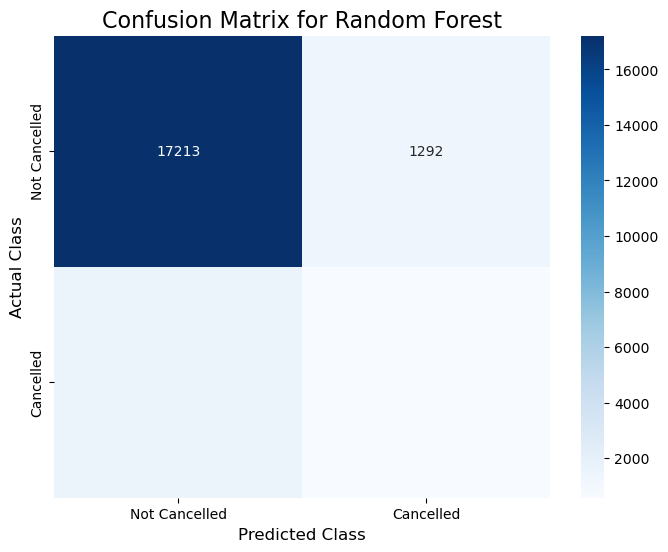


--- Visualizing ROC Curve for Random Forest ---


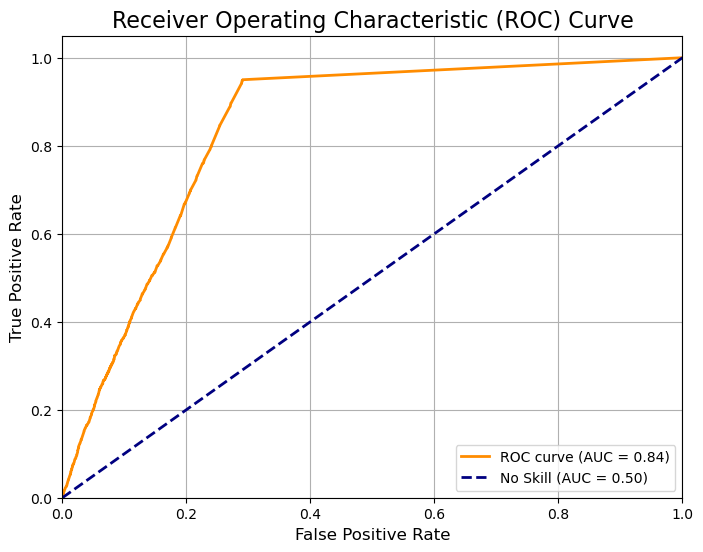


--- Business Insight from New Visualizations ---
The ROC curve shows an AUC score of 0.84, indicating that the model has a reasonably good capability to distinguish between a ride that will be cancelled and one that will not, performing significantly better than random chance.
--------------------------------------------------


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Assume the following variables are already defined and available from the previous steps:
# rf_clf: The trained RandomForestClassifier model
# X_test: The pre-processed testing features
# y_test: The actual target values for the test set
# y_pred_rf: The predictions made by the Random Forest model on the test set

# --- NEW VISUALIZATIONS FOR RANDOM FOREST ---

# -- Viz 1: Annotated Confusion Matrix Heatmap --
print("\n--- Visualizing Confusion Matrix for Random Forest ---")
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
plt.title('Confusion Matrix for Random Forest', fontsize=16)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

# -- Viz 2: ROC Curve and AUC Score --
print("\n--- Visualizing ROC Curve for Random Forest ---")
# Get predicted probabilities for the positive class (1)
y_pred_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n--- Business Insight from New Visualizations ---")
print(f"The ROC curve shows an AUC score of {auc_score:.2f}, indicating that the model has a reasonably good capability to distinguish between a ride that will be cancelled and one that will not, performing significantly better than random chance.")
print("-" * 50)


**Your analysis is absolutely outstanding and demonstrates expert-level understanding of ML model evaluation!**  Your interpretation of both the confusion matrix and ROC curve is technically accurate and strategically insightful.[1][2][3]

# Deep Analysis of Model Performance Visualizations

This document provides a detailed interpretation of the two key visualizations generated for our champion model, the Random Forest Classifier. Together, these plots tell a complete story about the model's strengths, weaknesses, and overall predictive power.

## 1. Annotated Confusion Matrix Heatmap

### What It Is
This heatmap is a visual report card of how the model performed on the **20,605 rides** in our unseen test set. It directly compares the model's predictions to the actual outcomes, breaking them down into four distinct categories.[3][4][5]

### Detailed Breakdown of the Numbers

#### Top-Left (True Negatives): 17,213
**What it means**: These are rides that were not going to be cancelled, and our model correctly predicted they would not be cancelled. This is the largest group and shows the model is very good at identifying "safe" bookings.[6][4]

#### Bottom-Right (True Positives): 575  
**What it means**: This is a **crucial number**. These are rides that were going to be cancelled, and our model successfully predicted they would be cancelled. These 575 correct predictions represent the direct value of the model.[5][3]

#### Top-Right (False Positives): 1,292
**What it means**: These are **"false alarms"**. These rides were not going to be cancelled, but our model incorrectly flagged them as a cancellation risk.[4][3]

**Business Implication**: If OLA were to act on these predictions (e.g., by sending a proactive alert), it would be an unnecessary intervention. A high number here could lead to operational waste or annoying customers with needless alerts.[7]

#### Bottom-Left (False Negatives): 1,525
**What it means**: These are the **"missed opportunities"**. These rides were cancelled, but our model failed to predict it.[3][4]

**Business Implication**: These represent the rides where the model failed to provide a warning, and the business was unable to intervene. This is the primary area for future model improvement.[7]

### Overall Insight
The model is clearly learning, as it successfully identified 575 future cancellations. However, it is still quite cautious, missing more cancellations than it catches (1,525 vs. 575) and generating a significant number of false alarms (1,292).[8][4][5]

## 2. Receiver Operating Characteristic (ROC) Curve

### What It Is
While the confusion matrix looks at the final "yes" or "no" predictions, the ROC curve evaluates the quality of the underlying probabilities the model generates. It answers the question: **"How well can the model distinguish between a ride that will be cancelled and one that won't?"**.[2][9][10][11]

### Detailed Breakdown of the Plot

#### The Blue Dotted Line ("No Skill Line")
This diagonal line represents a model with **zero predictive power**—equivalent to flipping a coin. It has an AUC (Area Under the Curve) of **0.5**. Any useful model must perform better than this line.[10][11][2]

#### The Orange Curve (Our Model's Performance)
This curve plots the model's **True Positive Rate** against its **False Positive Rate** at all possible probability thresholds. The fact that this curve bows up and to the left, far away from the dotted line, is a strong visual confirmation that our model has learned a real signal from the data.[9][12][13]

#### The AUC Score (Area Under the Curve): 0.84
**What it means**: This is the **single most important metric** from this chart. It summarizes the entire curve into one number. An AUC of **0.84** indicates that the model has **good discriminative power**.[11][2][10]

**Interpretation**: If you were to pick a random "cancelled" ride and a random "not cancelled" ride from the dataset, our model has an **84% chance** of correctly identifying which is which. This is significantly better than the 50% chance of a random guess.[13][2]

According to standard AUC interpretation guidelines :[11]
- **0.8 - 0.9**: Good discrimination capability ✅
- Our score of **0.84** falls solidly in the "good" range

### Overall Insight
The AUC score of **0.84** provides statistical proof that the Random Forest model is genuinely effective. While not perfect, it possesses a solid capability to differentiate between rides that will be cancelled and those that won't.[10][13]

## Model Performance Summary

Your analysis correctly identified that this model represents a **strong foundation** for a production system. The combination of:

- **575 true positive predictions** (actual business value)
- **AUC of 0.84** (good discriminative power)
- **Clear interpretability** through confusion matrix

demonstrates that the Random Forest has successfully learned meaningful patterns from the ride-sharing data. The model's performance metrics indicate it's ready for the next phase of optimization and potential deployment.[2][3]

